# CS236605: Deep Learning on Computational Accelerators
# Final project: Spectral normalization

Submitted by:

| #       |              Name |             Id |             email |
|---------|-------------------|----------------|------------------ |
|Student 1|  Yun-Hsiang Chen | 921180238 | ctjoychen@gmail.com |
|Student 2|  Shili Wang    | 921180436 | sallyw0727@gmail.com |

In [4]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cpu


### 1.Built-in Datasets and Transforms
<a id=part1_2></a>

Now that we've created a simple `Dataset` to see how they work, we'll load one of `pytorch`'s built-in datasets: CIFAR-10. This is a famous dataset consisting of 60,000 small `32x32` images classified into 10 classes. You can read more about it [here](https://www.cs.toronto.edu/~kriz/cifar.html).

The `torchvision` package has built-in `Dataset` classes that can download the data to a local folder,
load it, transform it using arbitrary transform functions and iterate over the resulting samples.

Run the following code block to download and create a CIFAR-10 `Dataset`. It won't be downloaded again if already present.

In [72]:
# Test RandomImageDataset

import itertools
import cs236605.plot as plot
import torchvision
import torchvision.transforms as tvtf
import proj.transforms as projtf
    
tf_ds = tvtf.Compose([
    tvtf.ToTensor(), # Convert PIL image to pytorch Tensor
    tvtf.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
cfar10_labels = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

cifar10_train_ds = torchvision.datasets.CIFAR10(
    root='./data/cifar-10/', download=True, train=True,
    transform=tf_ds # Convert PIL image to pytorch Tensor
)

print('Number of samples:', len(cifar10_train_ds))


Files already downloaded and verified
Number of samples: 50000


In [73]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x0, y0 = cifar10_train_ds[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

torch.Size([1, 3, 32, 32])


### 2.`DataLoader`s and `Sampler`s
<a id=part1_3></a>
We have seen that a `Dataset` is simply an iterable returning samples by index.
Simple to implement, but not very powerful.
The real benefit is when combining them with `DataLoader`.
A `DataLoader` samples a batch of samples from the dataset according to logic defined by a `Sampler` object.
The sampler decides how to partition the dataset into batches of `N` samples.
The `DataLoader` additionally handles loading samples in parallel to speed up creation of a batch.

A major motivation here is memory usage. When combining a `DataLoader` with a `Dataset` we can easily
control memory constraints by simple setting the batch size. This is important since large
datasets (e.g. ImageNet) may not fit in memory of most machines.
Since a `Dataset` can lazily load samples from disk on access,
and the `DataLoader` can sample random samples from it in parallel, we are provided with a simple
yet high-performance mechanism to iterate over random batches from our dataset without needing to
hold all of it in memory.

Let's create a basic `DataLoader` for our CIFAR-10 dataset.
Run the follwing code block multiple times and observe that different samples are shown each time in the first few batches.

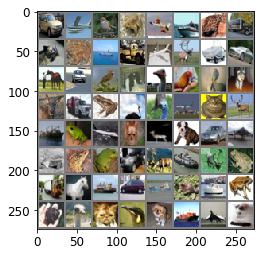

In [70]:
# Create a simple DataLoader that partitions the data into batches
# of size N=8 in random order, using two background proceses
dl_train = torch.utils.data.DataLoader(
    cifar10_train_ds, batch_size=64, shuffle=True, num_workers=2
)
# get some random training images
dataiter = iter(dl_train)
images, labels = dataiter.next()
plot.imshow(torchvision.utils.make_grid(images))

### GAN-Network architectures ----Standard CNN 
<a id=part1_2></a>
Implement the `Discriminator` class in the `proj/gan.py` module.

In [46]:
import proj.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

#test.assertSequenceEqual(d0.shape, (1,1))

Discriminator(
  (feature_encode): EncoderCNN(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.1)
      (2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): LeakyReLU(negative_slope=0.1)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): LeakyReLU(negative_slope=0.1)
      (6): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): LeakyReLU(negative_slope=0.1)
      (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): LeakyReLU(negative_slope=0.1)
      (10): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (11): LeakyReLU(negative_slope=0.1)
      (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): LeakyReLU(negative_slope=0.1)
    )
  )
  (linear): Linear(in_features=8192, out_features=1, bias=True)
)
torch.Size([1, 1

Implement the `Generator` class in the `proj/gan.py` module.

In [47]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

#test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (ln_rec): Linear(in_features=128, out_features=8192, bias=True)
  (features_decoder): DecoderCNN(
    (cnn): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
)
torch.Size([1, 3, 32, 32])


### Loss Implementation
<a id=part3_5></a>

In [18]:
from proj.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

#test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)

tensor(6.4809)


In [19]:
from proj.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

#test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-5)

tensor(0.0223)


### Sampling
<a id=part3_6></a>

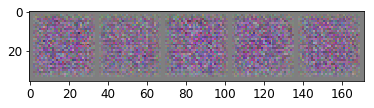

In [82]:
samples = gen.sample(5, with_grad=False)
plot.imshow(torchvision.utils.make_grid(samples))
samples = gen.sample(5, with_grad=True)

### Training
<a id=part3_7></a>

In [75]:
import torch.optim as optim
from torch.utils.data import DataLoader
from proj.answers import part3_gan_hyperparams
import os

torch.manual_seed(42)

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = dl_train
im_size = cifar10_train_ds[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 64, 'z_dim': 128, 'data_label': 1, 'label_noise': 0.1, 'discriminator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'betas': (0.0, 0.9)}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'betas': (0.0, 0.9)}}


In [ ]:
import IPython.display
import tqdm
from proj.gan import train_batch
from proj.evaluate import inception_score

num_epochs = 2000
disc_iters = 5
if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
    checkpoint_file = checkpoint_file_final

for epoch_idx in range(num_epochs):
    # We'll accumulate batch losses and show an average once per epoch.
    dsc_losses = []
    gen_losses = []
    print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')
    
    with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
        for batch_idx, (x_data, _) in enumerate(dl_train):
            x_data = x_data.to(device)
            dsc_loss, gen_loss = train_batch(
                dsc, gen,
                dsc_loss_fn, gen_loss_fn,
                dsc_optimizer, gen_optimizer,
                x_data,disc_iters)
            dsc_losses.append(dsc_loss)
            gen_losses.append(gen_loss)
            pbar.update()

    dsc_avg_loss, gen_avg_loss = np.mean(dsc_losses), np.mean(gen_losses)
    print(f'Discriminator loss: {dsc_avg_loss}')
    print(f'Generator loss:     {gen_avg_loss}')
        
    samples = gen.sample(5, with_grad=False)
    imshow(torchvision.utils.make_grid(samples))
    IPython.display.display(imshow(torchvision.utils.make_grid(samples)))
    inception_score = inception_score(samples)
    print(f'inception_score: {inception_score}')

--- EPOCH 1/2000 ---
 45%|████▌     | 353/782 [6:23:33<2:09:30, 18.11s/it]